In [758]:

from scipy.sparse import linalg
import openfermion as of
import openfermionpyscf as ofpyscf

$\text{Formal charge: valence electrons - nonbonding electrons - (1/2) \text{ bonding electrons}}$

In [759]:
# Set molecule parameters
geometry = [("He", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.772))]
basis = "sto-3g"
multiplicity = 1
charge = 1

# Perform electronic structure calculations and
# obtain Hamiltonian as an InteractionOperator
hamiltonian = ofpyscf.generate_molecular_hamiltonian(
    geometry, basis, multiplicity, charge
)

# Convert to a FermionOperator
hamiltonian_ferm_op = of.get_fermion_operator(hamiltonian)

print(hamiltonian_ferm_op)

1.3709254168911917 [] +
-2.577728496435193 [0^ 0] +
0.4715745430753901 [0^ 0^ 0 0] +
-0.0864599429280904 [0^ 0^ 0 2] +
-0.08645994292809045 [0^ 0^ 2 0] +
0.07281896711907539 [0^ 0^ 2 2] +
0.4715745430753901 [0^ 1^ 1 0] +
-0.0864599429280904 [0^ 1^ 1 2] +
-0.08645994292809045 [0^ 1^ 3 0] +
0.07281896711907539 [0^ 1^ 3 2] +
0.17292176000319465 [0^ 2] +
-0.08645994292809045 [0^ 2^ 0 0] +
0.07281896711907539 [0^ 2^ 0 2] +
0.33057284682223054 [0^ 2^ 2 0] +
0.018469323675948966 [0^ 2^ 2 2] +
-0.08645994292809045 [0^ 3^ 1 0] +
0.07281896711907539 [0^ 3^ 1 2] +
0.33057284682223054 [0^ 3^ 3 0] +
0.018469323675948966 [0^ 3^ 3 2] +
0.4715745430753901 [1^ 0^ 0 1] +
-0.0864599429280904 [1^ 0^ 0 3] +
-0.08645994292809045 [1^ 0^ 2 1] +
0.07281896711907539 [1^ 0^ 2 3] +
-2.577728496435193 [1^ 1] +
0.4715745430753901 [1^ 1^ 1 1] +
-0.0864599429280904 [1^ 1^ 1 3] +
-0.08645994292809045 [1^ 1^ 3 1] +
0.07281896711907539 [1^ 1^ 3 3] +
-0.08645994292809045 [1^ 2^ 0 1] +
0.07281896711907539 [1^ 2^ 0 3] +
0.

In [760]:
# Map to QubitOperator using the JWT
hamiltonian_jw = of.jordan_wigner(hamiltonian_ferm_op)

# Convert to Scipy sparse matrix
hamiltonian_jw_sparse = of.get_sparse_operator(hamiltonian_jw)

# Compute ground energy
eigs, _ = linalg.eigsh(hamiltonian_jw_sparse, k=1, which="SA")
ground_energy = eigs[0]

print("Ground_energy: {}".format(ground_energy))
#print("JWT transformed Hamiltonian:")
#print(hamiltonian_jw_sparse)

Ground_energy: -3.013485719295555


In [761]:

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="He 0 0 0; H+ 0 0 0.772",
    basis="sto-3g",
    charge=1,
    spin=0,
    
)

problem = driver.run()
print(problem)

In [762]:
fermionic_op = problem.hamiltonian.second_q_op()
#print(fermionic_op)

In [763]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
#print(qubit_jw_op)


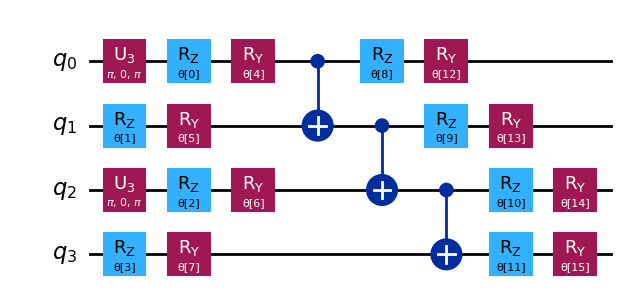

In [764]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
import numpy as np
# Initial States base on HatreeFock approximation 
reference_circuit = QuantumCircuit(4)
reference_circuit.x(0)
reference_circuit.x(2)
variational_form = TwoLocal(
    4,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)

ansatz = reference_circuit.compose(variational_form)
ansatz.decompose().draw('mpl')


In [765]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [766]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
x0 = np.random.uniform(low=0, high=np.pi, size=16)

In [767]:
# SciPy minimizer routine
from scipy.optimize import minimize
result = minimize(cost_func_vqe, x0, args=(ansatz, qubit_jw_op, estimator), method="COBYLA",options={'maxiter': 12000})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.383100379675659
       x: [ 2.279e-01  2.454e+00 ...  3.142e+00  1.619e+00]
    nfev: 381
   maxcv: 0.0

/tmp/ipykernel_26172/2399768393.py:37: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)


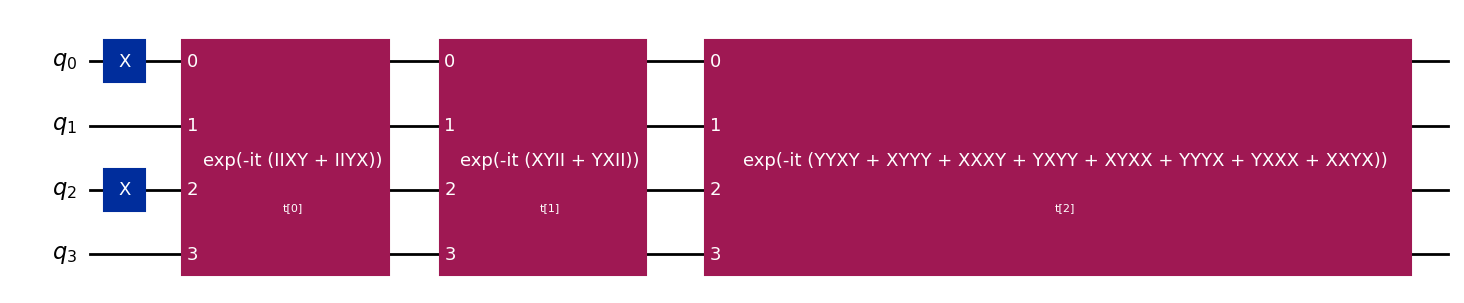

In [768]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP,SPSA,COBYLA, L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import matplotlib.pyplot as plt

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

#this is the optimization method
log = OptimizerLog()
# Sequential Least Squares Programming

Optimizer = SLSQP()

# Using Unitary Coupled Cluster as Variational Form and HatreeFock for intial states 
# The Variation Form does affect the number parameters(theta) which also impact the number of iteration and expectation value (ground-state energy)
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)

#Set the initial parameters(theta) as random - this will also affect the convergence of the plot and number of iteration.
vqe_solver.initial_point = np.random.random(ansatz.num_parameters)

ansatz.decompose().draw('mpl')

The initial state using HartreeFock

In [769]:
initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    )
print(problem.num_spatial_orbitals)
print(problem.num_particles)
print(initial_state)

2
(1, 1)
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [770]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
#from qiskit_aer import AerSimulator, Aer
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(problem)
print(res)



=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4.221949135775
  - computed part:      -4.221949135775
~ Nuclear repulsion energy (Hartree): 1.370925416891
> Total ground state energy (Hartree): -2.851023718884
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.45886857]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.387097988464]
    - computed part:      [0.0  0.0  0.387097988464]
  > Dipole moment (a.u.): [0.0  0.0  1.071770581536]  Total: 1.071770581536
                 (debye): [0.0  0.0  2.724168836175]  Total: 2.724168836175
 


We can see that 

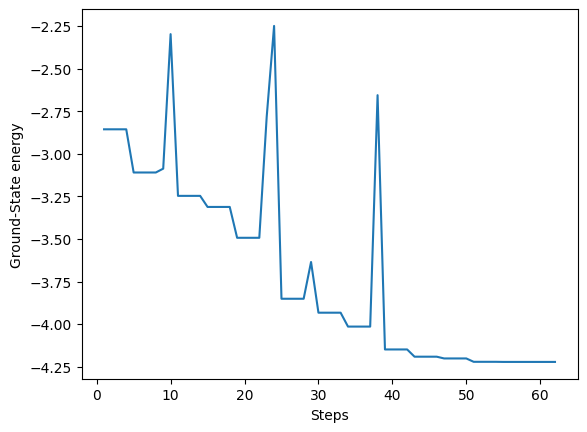

In [771]:
figfig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Ground-State energy')
plt.show()

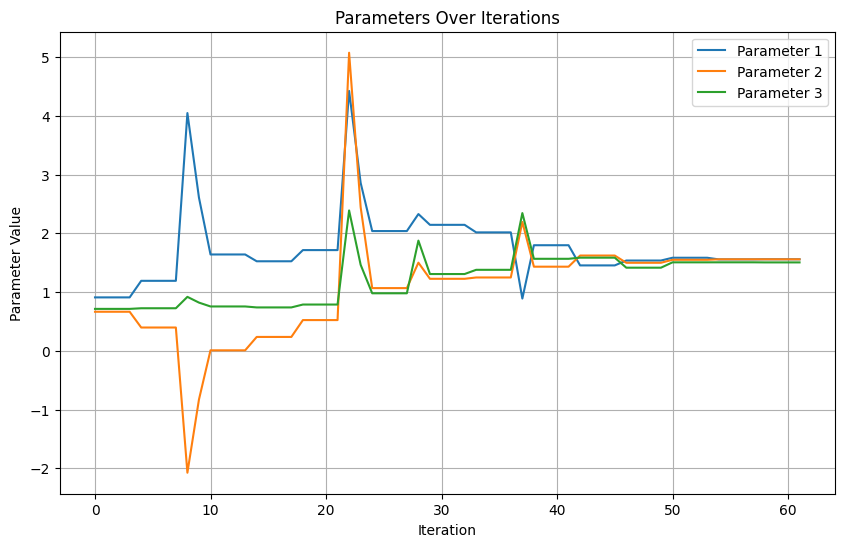

In [772]:
# Extract parameters
data = log.parameters
iterations = range(len(data))
param1 = [row[0] for row in data]
param2 = [row[1] for row in data]
param3 = [row[2] for row in data]

# Plotting the parameters
plt.figure(figsize=(10, 6))

plt.plot(iterations, param1, label='Parameter 1')
plt.plot(iterations, param2, label='Parameter 2')
plt.plot(iterations, param3, label='Parameter 3')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()